In [1]:
%load_ext autoreload
%autoreload 2

# standard python imports
import numpy as np
import matplotlib.pyplot as plt

# tidy3d imports
import tidy3d as td
import tidy3d.web as web

Using Tidy3D credentials from stored file


In [2]:
# 1 nanometer in units of microns (for conversion)
nm = 1e-3

# free space central wavelength
wavelength = 1

# thickness of ring and spacing
S = wavelength / 4

# height / thickness of ring
H = 400 * nm

# space between bottom PML and substrate (-z)
space_below_sub = 1 * wavelength

# thickness of substrate
thickness_sub = wavelength / 3

# side length of entire metalens (um)
side_length = 15 * wavelength

# projection length
#z0 = 15 * wavelength
z0 = 100 * wavelength

# Number of unit cells in each x and y direction (NxN grid)
N = int(side_length / 2 / S / 2)

# Define material properties at 600 nm
n_TiO2 = 2.40
n_SiO2 = 1.46
air = td.Medium(permittivity=1.0)
SiO2 = td.Medium(permittivity=n_SiO2**2)

# resolution control
grids_per_wavelength = 25

# Number of PML layers to use along z direction
npml = grids_per_wavelength

## Process Geometry

Next we need to do conversions to get the problem parameters ready to define the simulation.

In [3]:
# grid size (um)
dl = wavelength / grids_per_wavelength

# using the wavelength in microns, one can use td.C_0 (um/s) to get frequency in Hz
# wavelength_meters = wavelength * meters
f0 = td.C_0 / wavelength

# Define PML layers, for this we have no PML in x, y but `npml` cells in z
pml_layers = [npml, npml, npml]
pml_thickness = npml * dl
pml_layers = 3*[td.PML()]

# Compute the domain size in x, y (note: round down from side_length)
length_xy = N * S * 7
#length_xy = 15 * wavelength * 7 / 4
#length_xy = N * S * 7 - 5 * wavelength

# total domain size in z: (PML -> space -> substrate -> unit cell -> 1.7 focal lengths -> PML)
#buffer_z = z0
buffer_z = 1 * wavelength
length_z = space_below_sub + thickness_sub + H + buffer_z + 5 * space_below_sub

# construct simulation size array
sim_size_x = (length_z, length_xy, length_xy)
sim_size_y = (length_xy, length_z, length_xy)
sim_size_z = (length_xy, length_xy, length_z)

aperture_size = 1 * wavelength

# source settings

# Bandwidth in Hz
fwidth = f0 / 10.0

# Gaussian source offset; the source peak is at time t = offset/fwidth
offset = 4.

# time dependence of source
gaussian = td.GaussianPulse(freq0=f0, fwidth=fwidth, offset=offset)

# Simulation run time past the source decay (around t=2*offset/fwidth)
run_time = 40 / fwidth


In [4]:

# x-orientation

# create PEC plate with aperture
pec_plate_x = td.Structure(
    geometry=td.Box(
        center=[0, 0, 0],
        size=[thickness_sub, td.inf, td.inf]),
    medium=td.PEC)

aperture_x = td.Structure(
    geometry=td.Box(
        center=[0, 0, 0],
        size=[thickness_sub, aperture_size, aperture_size]),
    medium=air)

geometry_x = [pec_plate_x, aperture_x]

# create x+ (left of PEC) and x- (right of PEC) sources

source_xp = td.PlaneWave(
    center=(-length_z/4,0,0),
    size=(0, td.inf, td.inf),
    source_time=gaussian,
    direction='+',
    pol_angle=0)

source_xm = td.PlaneWave(
    center=(length_z/4,0,0),
    size=(0, td.inf, td.inf),
    source_time=gaussian,
    direction='-',
    pol_angle=np.pi)

# create x+ (right of PEC) and x- (left of PEC) monitors

monitor_xp = td.FieldMonitor(
    center=[length_z/4, 0., 0.],
    size=[0, length_xy, length_xy],
    freqs=[f0],
    name='near_field_x+')

monitor_xm = td.FieldMonitor(
    center=[-length_z/4, 0., 0.],
    size=[0, length_xy, length_xy],
    freqs=[f0],
    name='near_field_x-')


In [5]:

# y-orientation

# create PEC plate with aperture
pec_plate_y = td.Structure(
    geometry=td.Box(
        center=[0, 0, 0],
        size=[td.inf, thickness_sub, td.inf]),
    medium=td.PEC)

aperture_y = td.Structure(
    geometry=td.Box(
        center=[0, 0, 0],
        size=[aperture_size, thickness_sub, aperture_size]),
    medium=air)

geometry_y = [pec_plate_y, aperture_y]

# create y+ (left of PEC) and y- (right of PEC) sources

source_yp = td.PlaneWave(
    center=(0,-length_z/4,0),
    size=(td.inf, 0, td.inf),
    source_time=gaussian,
    direction='+',
    pol_angle=0)

source_ym = td.PlaneWave(
    center=(0,length_z/4,0),
    size=(td.inf, 0, td.inf),
    source_time=gaussian,
    direction='-',
    pol_angle=np.pi)

# create y+ (right of PEC) and y- (left of PEC) monitors

monitor_yp = td.FieldMonitor(
    center=[0., length_z/4, 0.],
    size=[length_xy, 0, length_xy],
    freqs=[f0],
    name='near_field_y+')

monitor_ym = td.FieldMonitor(
    center=[0., -length_z/4, 0.],
    size=[length_xy, 0, length_xy],
    freqs=[f0],
    name='near_field_y-')


In [6]:
# z-orientation

# create PEC plate with aperture
pec_plate_z = td.Structure(
    geometry=td.Box(
        center=[0, 0, 0],
        size=[td.inf, td.inf, thickness_sub]),
    medium=td.PEC)

aperture_z = td.Structure(
    geometry=td.Box(
        center=[0, 0, 0],
        size=[aperture_size, aperture_size, thickness_sub]),
    medium=air)

geometry_z = [pec_plate_z, aperture_z]

# create z+ (below PEC) and z- (above PEC) sources

source_zp = td.PlaneWave(
    center=(0,0,-length_z/4),
    size=(td.inf, td.inf, 0),
    source_time=gaussian,
    direction='+',
    pol_angle=0)

source_zm = td.PlaneWave(
    center=(0,0,length_z/4),
    size=(td.inf, td.inf, 0),
    source_time=gaussian,
    direction='-',
    pol_angle=np.pi)

# create z+ (above PEC) and z- (below PEC) monitors

monitor_zp = td.FieldMonitor(
    center=[0., 0., length_z/4],
    size=[length_xy, length_xy, 0],
    freqs=[f0],
    name='near_field_z+')

monitor_zm = td.FieldMonitor(
    center=[0., 0., -length_z/4],
    size=[length_xy, length_xy, 0],
    freqs=[f0],
    name='near_field_z-')


## Create Simulation

Now we can put everything together and define a simulation class to be run



In [7]:
sim_xp = td.Simulation(
    size=sim_size_x,
    grid_size=[dl, dl, dl],
    structures=geometry_x,
    sources=[source_xp],
    monitors=[monitor_xp],
    run_time=run_time,
    pml_layers=pml_layers
)

sim_xm = td.Simulation(
    size=sim_size_x,
    grid_size=[dl, dl, dl],
    structures=geometry_x,
    sources=[source_xm],
    monitors=[monitor_xm],
    run_time=run_time,
    pml_layers=pml_layers
)

sim_yp = td.Simulation(
    size=sim_size_y,
    grid_size=[dl, dl, dl],
    structures=geometry_y,
    sources=[source_yp],
    monitors=[monitor_yp],
    run_time=run_time,
    pml_layers=pml_layers
)

sim_ym = td.Simulation(
    size=sim_size_y,
    grid_size=[dl, dl, dl],
    structures=geometry_y,
    sources=[source_ym],
    monitors=[monitor_ym],
    run_time=run_time,
    pml_layers=pml_layers
)

sim_zp = td.Simulation(
    size=sim_size_z,
    grid_size=[dl, dl, dl],
    structures=geometry_z,
    sources=[source_zp],
    monitors=[monitor_zp],
    run_time=run_time,
    pml_layers=pml_layers
)

sim_zm = td.Simulation(
    size=sim_size_z,
    grid_size=[dl, dl, dl],
    structures=geometry_z,
    sources=[source_zm],
    monitors=[monitor_zm],
    run_time=run_time,
    pml_layers=pml_layers
)

/Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/components/simulation.py:372: RuntimeWarning: divide by zero encountered in double_scalars
  lambda_min = C_0 / f_average / n_material


## Visualize Geometry

Lets take a look and make sure everything is defined properly


/Users/shashwat/Documents/flexcompute/repos/venvs/tidy3d-env/lib/python3.9/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]
/Users/shashwat/Documents/flexcompute/repos/venvs/tidy3d-env/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


<Figure size 1440x432 with 4 Axes>

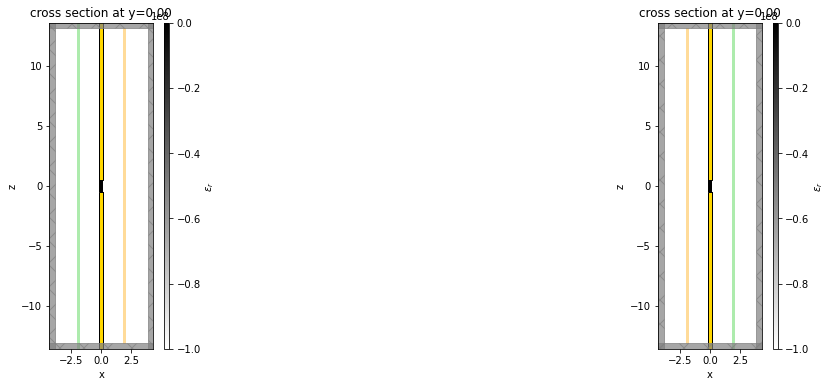

<Figure size 1440x432 with 4 Axes>

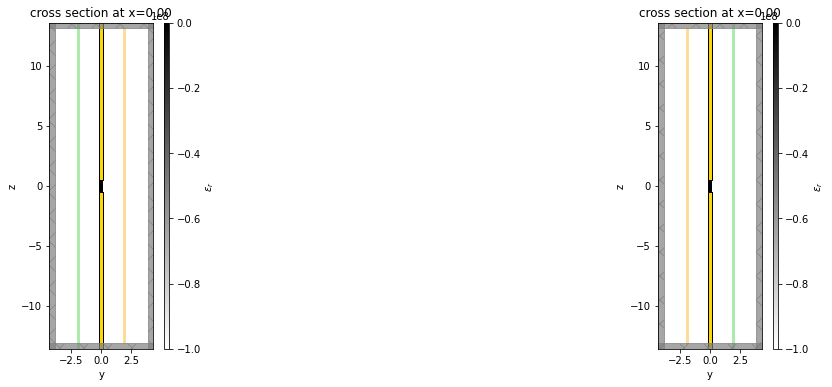

<Figure size 1440x432 with 4 Axes>

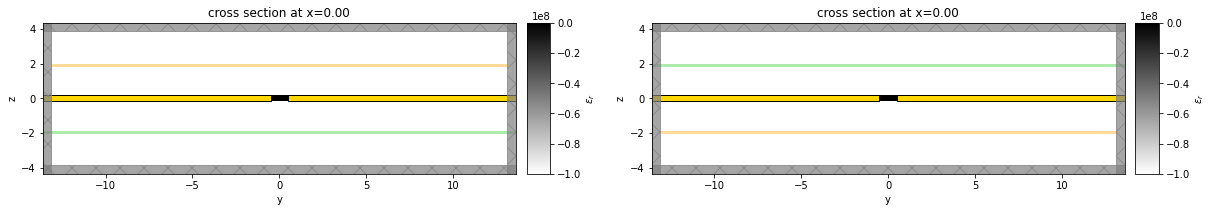

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
sim_xp.plot_eps(y=0, ax=ax1);
sim_xm.plot_eps(y=0, ax=ax2);

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
sim_yp.plot_eps(x=0, ax=ax1);
sim_ym.plot_eps(x=0, ax=ax2);

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
sim_zp.plot_eps(x=0, ax=ax1);
sim_zm.plot_eps(x=0, ax=ax2);

## Run Simulation

Now we can run the simulation over time and measure the results to plot


In [9]:
# Run simulation
import tidy3d.web as web

batch = web.Batch(simulations=
                  {'sim_x+': sim_xp,
                   'sim_x-': sim_xm,
                   'sim_y+': sim_yp,
                   'sim_y-': sim_ym,
                   'sim_z+': sim_zp,
                   'sim_z-': sim_zm})
batch_results = batch.run(path_dir='data/batch/')

sim_data = []
for task_name, sim_data_item in batch_results:
    sim_data.append(sim_data_item)


[15:37:28] INFO     Uploaded task 'sim_x+' with task_id                         ]8;id=978734;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=656825;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py#108\108]8;;\
                    'f7390066-d2c5-4611-9d96-bfb1c40430ff'.                                  

           INFO     Uploaded task 'sim_x-' with task_id                         ]8;id=268338;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=628482;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py#108\108]8;;\
                    '0a9b5e06-3e9e-452c-aac2-89720f9d00cf'.                                  

[15:37:29] INFO     Uploaded task 'sim_y+' with task_id                         ]8;id=155567;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=314929;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py#108\108]8;;\
                    'df50f9fd-cef1-406e-b6b8-4121b1b26f6e'.                                  

[15:37:30] INFO     Uploaded task 'sim_y-' with task_id                         ]8;id=918511;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=808306;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py#108\108]8;;\
                    '6d2962e9-9c6c-4547-8584-d40f86db9254'.                                  

           INFO     Uploaded task 'sim_z+' with task_id                         ]8;id=797813;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=534032;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py#108\108]8;;\
                    '30b52163-d583-42db-98d5-7692fd4e2c3e'.                                  

[15:37:31] INFO     Uploaded task 'sim_z-' with task_id                         ]8;id=461012;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=97899;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py#108\108]8;;\
                    '2b8f133c-b3b1-413a-b9ce-75a2ac056d94'.                                  

Output()

[15:42:20] INFO     downloading file "monitor_data.hdf5" to                     ]8;id=236897;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=690519;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py#483\483]8;;\
                    "data/batch/sim_x+.hdf5"                                                 

Output()

[15:42:30] INFO     downloading file "monitor_data.hdf5" to                     ]8;id=783035;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=958341;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py#483\483]8;;\
                    "data/batch/sim_x-.hdf5"                                                 

Output()

[15:42:46] INFO     downloading file "monitor_data.hdf5" to                     ]8;id=77759;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=988500;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py#483\483]8;;\
                    "data/batch/sim_y+.hdf5"                                                 

Output()

[15:42:56] INFO     downloading file "monitor_data.hdf5" to                     ]8;id=874436;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=535149;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py#483\483]8;;\
                    "data/batch/sim_y-.hdf5"                                                 

Output()

[15:43:10] INFO     downloading file "monitor_data.hdf5" to                     ]8;id=146378;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=849988;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py#483\483]8;;\
                    "data/batch/sim_z+.hdf5"                                                 

Output()

[15:43:20] INFO     downloading file "monitor_data.hdf5" to                     ]8;id=560421;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=529885;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py#483\483]8;;\
                    "data/batch/sim_z-.hdf5"                                                 

Output()

[15:43:34] INFO     downloading file "monitor_data.hdf5" to                     ]8;id=905122;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=829225;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py#483\483]8;;\
                    "./f7390066-d2c5-4611-9d96-bfb1c40430ff.hdf5"                            

Output()

[15:43:44] INFO     loading SimulationData from                                 ]8;id=542500;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=175274;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py#302\302]8;;\
                    ./f7390066-d2c5-4611-9d96-bfb1c40430ff.hdf5                              

[15:43:45] INFO     downloading file "monitor_data.hdf5" to                     ]8;id=189502;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=849990;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py#483\483]8;;\
                    "./0a9b5e06-3e9e-452c-aac2-89720f9d00cf.hdf5"                            

Output()

[15:44:00] INFO     loading SimulationData from                                 ]8;id=457455;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=619901;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py#302\302]8;;\
                    ./0a9b5e06-3e9e-452c-aac2-89720f9d00cf.hdf5                              

           INFO     downloading file "monitor_data.hdf5" to                     ]8;id=418356;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=412802;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py#483\483]8;;\
                    "./df50f9fd-cef1-406e-b6b8-4121b1b26f6e.hdf5"                            

Output()

[15:44:12] INFO     loading SimulationData from                                 ]8;id=774045;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=636755;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py#302\302]8;;\
                    ./df50f9fd-cef1-406e-b6b8-4121b1b26f6e.hdf5                              

           INFO     downloading file "monitor_data.hdf5" to                     ]8;id=329977;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=83989;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py#483\483]8;;\
                    "./6d2962e9-9c6c-4547-8584-d40f86db9254.hdf5"                            

Output()

[15:44:29] INFO     loading SimulationData from                                 ]8;id=886385;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=256571;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py#302\302]8;;\
                    ./6d2962e9-9c6c-4547-8584-d40f86db9254.hdf5                              

[15:44:30] INFO     downloading file "monitor_data.hdf5" to                     ]8;id=347989;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=25990;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py#483\483]8;;\
                    "./30b52163-d583-42db-98d5-7692fd4e2c3e.hdf5"                            

Output()

[15:44:41] INFO     loading SimulationData from                                 ]8;id=558646;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=788914;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py#302\302]8;;\
                    ./30b52163-d583-42db-98d5-7692fd4e2c3e.hdf5                              

           INFO     downloading file "monitor_data.hdf5" to                     ]8;id=377959;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=950090;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py#483\483]8;;\
                    "./2b8f133c-b3b1-413a-b9ce-75a2ac056d94.hdf5"                            

Output()

[15:44:57] INFO     loading SimulationData from                                 ]8;id=558253;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=796631;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py#302\302]8;;\
                    ./2b8f133c-b3b1-413a-b9ce-75a2ac056d94.hdf5                              

We now can inspect the field patterns on the area monitors using the Tidy3D built in field visualization methods.

<Figure size 1080x252 with 6 Axes>

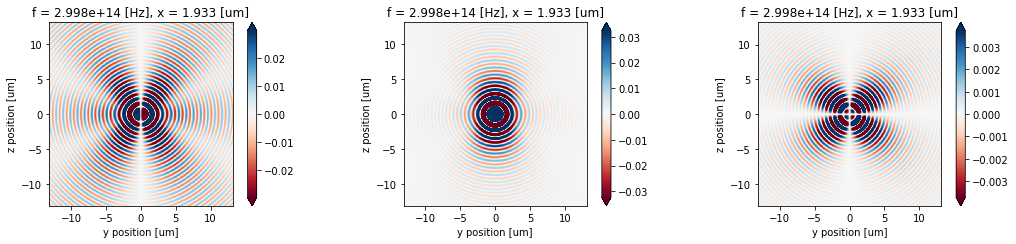

<Figure size 1080x252 with 6 Axes>

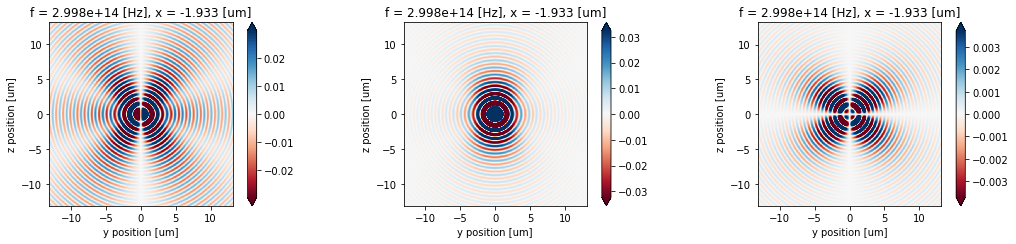

<Figure size 1080x252 with 6 Axes>

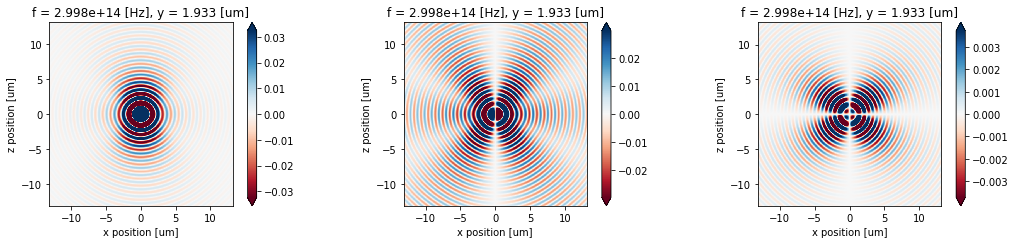

<Figure size 1080x252 with 6 Axes>

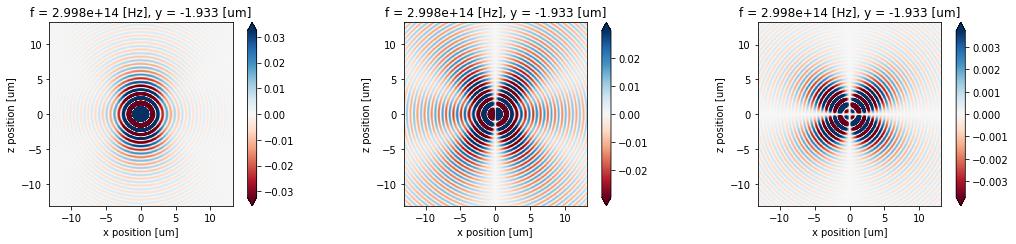

<Figure size 1080x252 with 6 Axes>

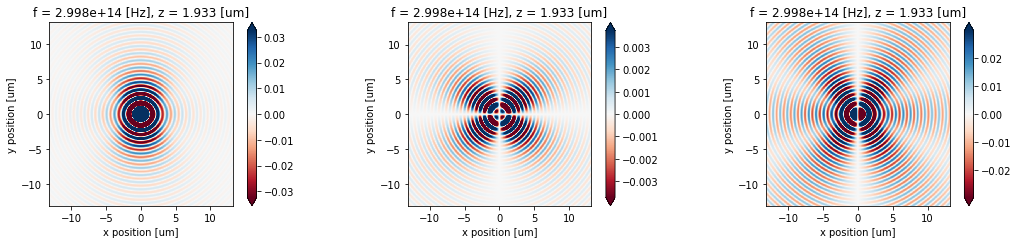

<Figure size 1080x252 with 6 Axes>

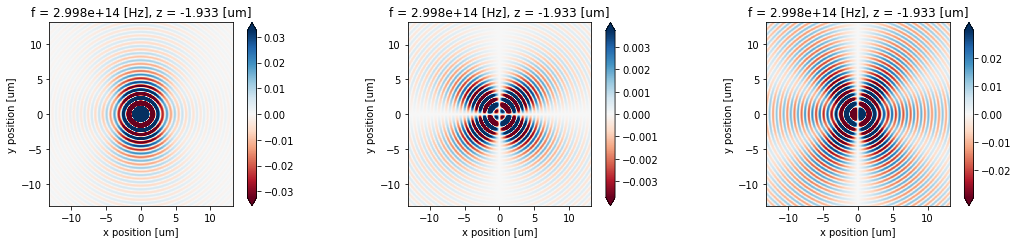

In [10]:

# x

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(15, 3.5))

sim_data[0].plot_field(field_monitor_name='near_field_x+', field_name='Ex', x=length_z/4, val='real', freq=f0, ax=ax1)
sim_data[0].plot_field(field_monitor_name='near_field_x+', field_name='Ey', x=length_z/4, val='real', freq=f0, ax=ax2)
sim_data[0].plot_field(field_monitor_name='near_field_x+', field_name='Ez', x=length_z/4, val='real', freq=f0, ax=ax3)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(15, 3.5))

sim_data[1].plot_field(field_monitor_name='near_field_x-', field_name='Ex', x=-length_z/4, val='real', freq=f0, ax=ax1)
sim_data[1].plot_field(field_monitor_name='near_field_x-', field_name='Ey', x=-length_z/4, val='real', freq=f0, ax=ax2)
sim_data[1].plot_field(field_monitor_name='near_field_x-', field_name='Ez', x=-length_z/4, val='real', freq=f0, ax=ax3)

# y

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(15, 3.5))

sim_data[2].plot_field(field_monitor_name='near_field_y+', field_name='Ex', y=length_z/4, val='real', freq=f0, ax=ax1)
sim_data[2].plot_field(field_monitor_name='near_field_y+', field_name='Ey', y=length_z/4, val='real', freq=f0, ax=ax2)
sim_data[2].plot_field(field_monitor_name='near_field_y+', field_name='Ez', y=length_z/4, val='real', freq=f0, ax=ax3)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(15, 3.5))

sim_data[3].plot_field(field_monitor_name='near_field_y-', field_name='Ex', y=-length_z/4, val='real', freq=f0, ax=ax1)
sim_data[3].plot_field(field_monitor_name='near_field_y-', field_name='Ey', y=-length_z/4, val='real', freq=f0, ax=ax2)
sim_data[3].plot_field(field_monitor_name='near_field_y-', field_name='Ez', y=-length_z/4, val='real', freq=f0, ax=ax3)

# z

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(15, 3.5))

sim_data[4].plot_field(field_monitor_name='near_field_z+', field_name='Ex', z=length_z/4, val='real', freq=f0, ax=ax1)
sim_data[4].plot_field(field_monitor_name='near_field_z+', field_name='Ey', z=length_z/4, val='real', freq=f0, ax=ax2)
sim_data[4].plot_field(field_monitor_name='near_field_z+', field_name='Ez', z=length_z/4, val='real', freq=f0, ax=ax3)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(15, 3.5))

sim_data[5].plot_field(field_monitor_name='near_field_z-', field_name='Ex', z=-length_z/4, val='real', freq=f0, ax=ax1)
sim_data[5].plot_field(field_monitor_name='near_field_z-', field_name='Ey', z=-length_z/4, val='real', freq=f0, ax=ax2)
sim_data[5].plot_field(field_monitor_name='near_field_z-', field_name='Ez', z=-length_z/4, val='real', freq=f0, ax=ax3)

plt.show()


In [11]:

from tidy3d.plugins import Near2Far

n2f_xp = Near2Far(sim_data[0], mons=[monitor_xp], frequency=f0)
n2f_xm = Near2Far(sim_data[1], mons=[monitor_xm], frequency=f0)

n2f_yp = Near2Far(sim_data[2], mons=[monitor_yp], frequency=f0)
n2f_ym = Near2Far(sim_data[3], mons=[monitor_ym], frequency=f0)

n2f_zp = Near2Far(sim_data[4], mons=[monitor_zp], frequency=f0)
n2f_zm = Near2Far(sim_data[5], mons=[monitor_zm], frequency=f0)


In [12]:

# points to project to
num_far_u = 40
num_far_v = 40
us_n2f = length_xy * np.linspace(-0.5, 0.5, num_far_u)
vs_n2f = length_xy * np.linspace(-0.5, 0.5, num_far_v)

# temp
#num_far_u = 1
#num_far_v = 1
#us_n2f = [0.0]
#vs_n2f = [0.0]

# initialize the far field values
Es_xp = np.zeros((3, num_far_u, num_far_v), dtype=complex)
Es_xm = np.zeros((3, num_far_u, num_far_v), dtype=complex)

Es_yp = np.zeros((3, num_far_u, num_far_v), dtype=complex)
Es_ym = np.zeros((3, num_far_u, num_far_v), dtype=complex)

Es_zp = np.zeros((3, num_far_u, num_far_v), dtype=complex)
Es_zm = np.zeros((3, num_far_u, num_far_v), dtype=complex)

from rich.progress import track

# loop through points in the output plane
for i in track(range(num_far_u), description='Performing far-field transformation...'):

    u = us_n2f[i]
    for j in range(num_far_v):
        v = vs_n2f[j]

        # x
        E, H = n2f_xp.fields_cartesian(z0, u, v)
        Es_xp[:, i, j] = np.squeeze(E)

        E, H = n2f_xm.fields_cartesian(-z0, u, v)
        Es_xm[:, i, j] = np.squeeze(E)

        # y
        E, H = n2f_yp.fields_cartesian(u, z0, v)
        Es_yp[:, i, j] = np.squeeze(E)

        E, H = n2f_ym.fields_cartesian(u, -z0, v)
        Es_ym[:, i, j] = np.squeeze(E)

        # z
        E, H = n2f_zp.fields_cartesian(u, v, z0)
        Es_zp[:, i, j] = np.squeeze(E)

        E, H = n2f_zm.fields_cartesian(u, v, -z0)
        Es_zm[:, i, j] = np.squeeze(E)


Output()

<Figure size 720x360 with 12 Axes>

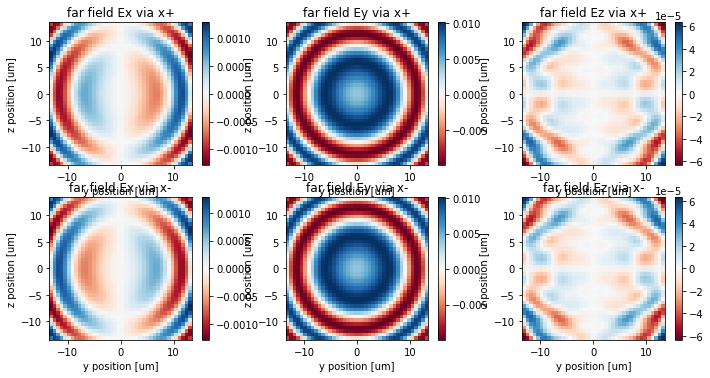

<Figure size 720x360 with 12 Axes>

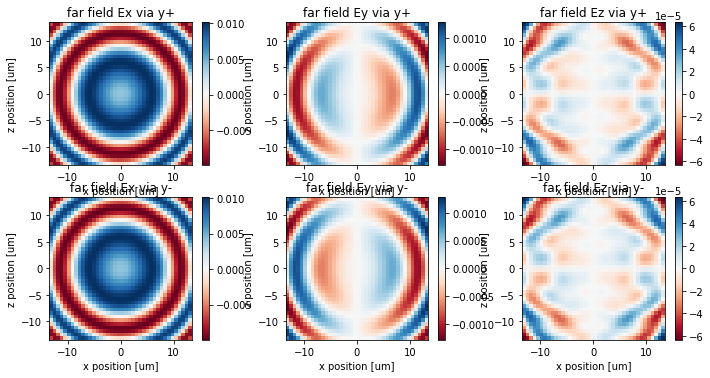

<Figure size 720x360 with 12 Axes>

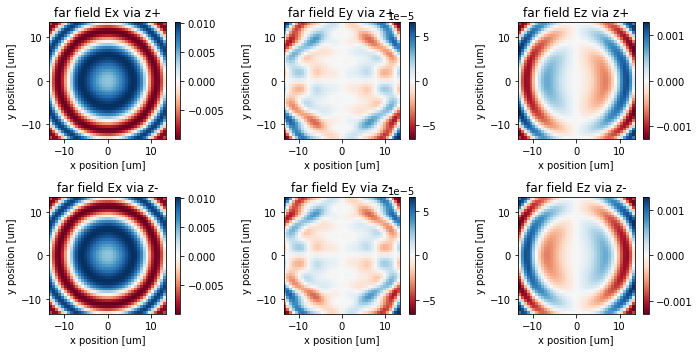

In [13]:
# plot everything
# fig, (axes_near, axes_near_ref, axes_far_ref, axes_near2far, axes_near2far_ref) =  plt.subplots(5, 3)
# fig.set_size_inches(13, 15)

def pmesh(xs, ys, array, ax, cmap):
    im = ax.pcolormesh(xs, ys, array.T, cmap=cmap, shading='auto')
    return im

func = 'real'
def plotfunc(val):
    return np.real(val)

fig, (axes_xp, axes_xm) =  plt.subplots(2, 3)
fig.set_size_inches(10, 5)
fig.tight_layout()

# Far field x+
for ax, direction, E in zip(axes_xp, 'xyz', Es_xp):
    im = pmesh(us_n2f, vs_n2f, plotfunc(E), ax=ax, cmap='RdBu')
    ax.set_title(f'far field E{direction} via x+')
    ax.set_aspect(1)
    ax.set_xlabel('y position [um]')
    ax.set_ylabel('z position [um]')
    plt.colorbar(im, ax=ax)

# Far field x-
for ax, direction, E in zip(axes_xm, 'xyz', Es_xm):
    im = pmesh(us_n2f, vs_n2f, plotfunc(E), ax=ax, cmap='RdBu')
    ax.set_title(f'far field E{direction} via x-')
    ax.set_aspect(1)
    ax.set_xlabel('y position [um]')
    ax.set_ylabel('z position [um]')
    plt.colorbar(im, ax=ax)

    
fig, (axes_yp, axes_ym) =  plt.subplots(2, 3)
fig.set_size_inches(10, 5)
fig.tight_layout()

# Far field y+
for ax, direction, E in zip(axes_yp, 'xyz', Es_yp):
    im = pmesh(us_n2f, vs_n2f, plotfunc(E), ax=ax, cmap='RdBu')
    ax.set_title(f'far field E{direction} via y+')
    ax.set_aspect(1)
    ax.set_xlabel('x position [um]')
    ax.set_ylabel('z position [um]')
    plt.colorbar(im, ax=ax)

# Far field y-
for ax, direction, E in zip(axes_ym, 'xyz', Es_ym):
    im = pmesh(us_n2f, vs_n2f, plotfunc(E), ax=ax, cmap='RdBu')
    ax.set_title(f'far field E{direction} via y-')
    ax.set_aspect(1)
    ax.set_xlabel('x position [um]')
    ax.set_ylabel('z position [um]')
    plt.colorbar(im, ax=ax)

    
fig, (axes_zp, axes_zm) =  plt.subplots(2, 3)
fig.set_size_inches(10, 5)
fig.tight_layout()

# Far field z+
for ax, direction, E in zip(axes_zp, 'xyz', Es_zp):
    im = pmesh(us_n2f, vs_n2f, plotfunc(E), ax=ax, cmap='RdBu')
    ax.set_title(f'far field E{direction} via z+')
    ax.set_aspect(1)
    ax.set_xlabel('x position [um]')
    ax.set_ylabel('y position [um]')
    plt.colorbar(im, ax=ax)

# Far field z-
for ax, direction, E in zip(axes_zm, 'xyz', Es_zm):
    im = pmesh(us_n2f, vs_n2f, plotfunc(E), ax=ax, cmap='RdBu')
    ax.set_title(f'far field E{direction} via z-')
    ax.set_aspect(1)
    ax.set_xlabel('x position [um]')
    ax.set_ylabel('y position [um]')
    plt.colorbar(im, ax=ax)

fig.tight_layout()
plt.show()